<a href="https://colab.research.google.com/github/toooo-pharma/AI-/blob/main/AI%E5%89%B5%E8%96%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#サンプルデータ作成
import pandas as pd

# 一部NSAIDs＋仮IC50（例値, nMとする）
data = {
    "Name": ["アスピリン", "イブプロフェン", "ナプロキセン", "ケトプロフェン", "インドメタシン", "ジクロフェナク", "メフェナム酸"],
    "SMILES": [
        "CC(=O)OC1=CC=CC=C1C(=O)O",       # アスピリン
        "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # イブプロフェン
        "CC(C)C1=CC=C(C=C1)C(O)=O",       # ナプロキセン
        "CC(C)C1=CC=C(C=C1C(=O)C)C(O)=O", # ケトプロフェン
        "CC(=O)N(C)C1=CC=CC2=CC=CC=C12", # インドメタシン
        "Clc1ccc(cc1)Nc2c(Cl)cccc2", # ジクロフェナク
        "CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C", # メフェナム酸
    ],
    "IC50": [80, 30, 50, 25, 10, 12, 20] # 仮の活性値
}
df = pd.DataFrame(data)
df

,Name,SMILES,IC50
0,アスピリン,CC(=O)OC1=CC=CC=C1C(=O)O,80
1,イブプロフェン,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,30
2,ナプロキセン,CC(C)C1=CC=C(C=C1)C(O)=O,50
3,ケトプロフェン,CC(C)C1=CC=C(C=C1C(=O)C)C(O)=O,25
4,インドメタシン,CC(=O)N(C)C1=CC=CC2=CC=CC=C12,10
5,ジクロフェナク,Clc1ccc(cc1)Nc2c(Cl)cccc2,12
6,メフェナム酸,CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C,20


In [21]:
#分子記述計算
!pip install rdkit-pypi matplotlib

from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors

descriptor_names = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors']
calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return list(calc.CalcDescriptors(mol))
    else:
        return [None] * len(descriptor_names)

desc = df['SMILES'].apply(smiles_to_descriptors)
desc_df = pd.DataFrame(desc.tolist(), columns=descriptor_names)
df_desc = pd.concat([df, desc_df], axis=1).dropna()
df_desc

,Name,SMILES,IC50,MolWt,MolLogP,NumHDonors,NumHAcceptors
0,アスピリン,CC(=O)OC1=CC=CC=C1C(=O)O,80,180.159,1.31010,1,3
1,イブプロフェン,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,30,206.285,3.07320,1,1
2,ナプロキセン,CC(C)C1=CC=C(C=C1)C(O)=O,50,164.204,2.50820,1,1
3,ケトプロフェン,CC(C)C1=CC=C(C=C1C(=O)C)C(O)=O,25,206.241,2.71080,1,2
4,インドメタシン,CC(=O)N(C)C1=CC=CC2=CC=CC=C12,10,199.253,2.82250,0,1
5,ジクロフェナク,Clc1ccc(cc1)Nc2c(Cl)cccc2,12,238.117,4.73700,1,1
6,メフェナム酸,CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C,20,225.291,3.55574,1,1


In [22]:
#QSAR
from sklearn.ensemble import RandomForestRegressor

X = df_desc[descriptor_names]
y = df_desc["IC50"]

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

y_pred = model.predict(X)
df_desc["Predicted_IC50"] = y_pred
df_desc

,Name,SMILES,IC50,MolWt,MolLogP,NumHDonors,NumHAcceptors,Predicted_IC50
0,アスピリン,CC(=O)OC1=CC=CC=C1C(=O)O,80,180.159,1.31010,1,3,67.55
1,イブプロフェン,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,30,206.285,3.07320,1,1,25.74
2,ナプロキセン,CC(C)C1=CC=C(C=C1)C(O)=O,50,164.204,2.50820,1,1,44.32
3,ケトプロフェン,CC(C)C1=CC=C(C=C1C(=O)C)C(O)=O,25,206.241,2.71080,1,2,24.95
4,インドメタシン,CC(=O)N(C)C1=CC=CC2=CC=CC=C12,10,199.253,2.82250,0,1,15.77
5,ジクロフェナク,Clc1ccc(cc1)Nc2c(Cl)cccc2,12,238.117,4.73700,1,1,14.86
6,メフェナム酸,CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C,20,225.291,3.55574,1,1,20.42


In [30]:
import pandas as pd
import random
from rdkit import Chem
from rdkit.Chem import AllChem

# --- 1. 変異関数（前回の例を流用） ---

def add_methyl(smiles):
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        if atom.GetDegree() < atom.GetTotalValence():
            emol = Chem.RWMol(mol)
            idx = atom.GetIdx()
            cidx = emol.AddAtom(Chem.Atom('C'))
            emol.AddBond(idx, cidx, Chem.BondType.SINGLE)
            try:
                new_mol = emol.GetMol()
                Chem.SanitizeMol(new_mol)
                return Chem.MolToSmiles(new_mol)
            except:
                continue
    return None

def add_halogen(smiles, halogen="Cl"):
    mol = Chem.MolFromSmiles(smiles)
    aromatic_carbons = [a.GetIdx() for a in mol.GetAtoms() if a.GetIsAromatic() and a.GetSymbol() == "C"]
    for idx in aromatic_carbons:
        emol = Chem.RWMol(mol)
        emol.AddAtom(Chem.Atom(halogen))
        emol.AddBond(idx, emol.GetNumAtoms()-1, Chem.BondType.SINGLE)
        try:
            new_mol = emol.GetMol()
            Chem.SanitizeMol(new_mol)
            return Chem.MolToSmiles(new_mol)
        except:
            continue
    return None

def add_hydroxy(smiles):
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == "C" and atom.GetTotalNumHs() > 0:
            emol = Chem.RWMol(mol)
            oidx = emol.AddAtom(Chem.Atom('O'))
            hidx = emol.AddAtom(Chem.Atom('H'))
            emol.AddBond(atom.GetIdx(), oidx, Chem.BondType.SINGLE)
            emol.AddBond(oidx, hidx, Chem.BondType.SINGLE)
            try:
                new_mol = emol.GetMol()
                Chem.SanitizeMol(new_mol)
                return Chem.MolToSmiles(new_mol)
            except:
                continue
    return None

# --- 2. ベース分子リスト（NSAIDs例） ---
base_smiles_list = [
    "CC(=O)OC1=CC=CC=C1C(=O)O",       # アスピリン
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # イブプロフェン
    "CC(C)C1=CC=C(C=C1)C(O)=O",       # ナプロキセン
    "CC(C)C1=CC=C(C=C1C(=O)C)C(O)=O", # ケトプロフェン
    "CC(=O)N(C)C1=CC=CC2=CC=CC=C12", # インドメタシン
    "Clc1ccc(cc1)Nc2c(Cl)cccc2", # ジクロフェナク
    "CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C", # メフェナム酸
]
base_names = [
    "アスピリン",
    "イブプロフェン",
    "ナプロキセン",
    "ケトプロフェン",
    "インドメタシン",
    "ジクロフェナク",
    "メフェナム酸"
]

# SMILES→薬品名辞書を自動生成
base_smiles_to_name = dict(zip(base_smiles_list, base_names))

# --- 3. 変異法のリスト化 ---
mutate_funcs = [
    add_methyl,
    add_hydroxy,
    lambda s: add_halogen(s, "Cl"),
]

# --- 4. SMARTS反応も使う例 ---
def smarts_chlorinate(smiles):
    mol = Chem.MolFromSmiles(smiles)
    rxn = AllChem.ReactionFromSmarts('[cH:1]>>[c:1]Cl')
    ps = rxn.RunReactants((mol,))
    return [Chem.MolToSmiles(p[0]) for p in ps if p and Chem.MolToSmiles(p[0])]

# --- 5. 生成SMILESをすべて集約 ---
generated = []
for base in base_smiles_list:
    for func in mutate_funcs:
        smi = func(base)
        if smi:
            generated.append({"base_smiles": base, "generated_smiles": smi, "method": func.__name__})
    # SMARTS反応は複数生成されるので全部追加
    mutants = smarts_chlorinate(base)
    for smi in mutants:
        generated.append({"base_smiles": base, "generated_smiles": smi, "method": "smarts_chlorinate"})

# --- 6. DataFrame化・重複排除 ---
df_gen = pd.DataFrame(generated)
df_gen = df_gen.drop_duplicates(subset=["generated_smiles"]).reset_index(drop=True)
display(df_gen)

[06:40:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[06:40:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[06:40:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[06:40:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[06:40:51] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[06:40:51] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[06:40:51] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[06:40:51] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


,base_smiles,generated_smiles,method
0,CC(=O)OC1=CC=CC=C1C(=O)O,CCC(=O)Oc1ccccc1C(=O)O,add_methyl
1,CC(=O)OC1=CC=CC=C1C(=O)O,[H]OCC(=O)Oc1ccccc1C(=O)O,add_hydroxy
2,CC(=O)OC1=CC=CC=C1C(=O)O,CC(=O)Oc1c(Cl)cccc1C(=O)O,<lambda>
3,CC(=O)OC1=CC=CC=C1C(=O)O,CC(=O)Oc1cc(Cl)ccc1C(=O)O,smarts_chlorinate
4,CC(=O)OC1=CC=CC=C1C(=O)O,CC(=O)Oc1ccc(Cl)cc1C(=O)O,smarts_chlorinate
5,CC(=O)OC1=CC=CC=C1C(=O)O,CC(=O)Oc1cccc(Cl)c1C(=O)O,smarts_chlorinate
6,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,CCC(C)Cc1ccc(C(C)C(=O)O)cc1,add_methyl
7,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,[H]OCC(C)Cc1ccc(C(C)C(=O)O)cc1,add_hydroxy
8,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,CC(C)Cc1ccc(C(C)C(=O)O)cc1Cl,<lambda>
9,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,CC(C)Cc1ccc(C(C)C(=O)O)c(Cl)c1,smarts_chlorinate


In [25]:
#新規の薬物のスクリーニング
# --- QSAR予測（IC50）をgenerated_smiles列に自動付与 ---
results = []

for idx, row in df_gen.iterrows():
    desc = smiles_to_descriptors(row["generated_smiles"])
    if None not in desc:
        pred_ic50 = model.predict([desc])[0]
        results.append({
            "base_smiles": row["base_smiles"],
            "generated_smiles": row["generated_smiles"],
            "method": row["method"],
            "Predicted_IC50": pred_ic50
        })

df_screen = pd.DataFrame(results)
df_screen = df_screen.sort_values("Predicted_IC50").reset_index(drop=True)
display(df_screen)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

,base_smiles,generated_smiles,method,Predicted_IC50
0,CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C,Cc1ccc(C(=O)Nc2cccc(Cl)c2C)cc1,smarts_chlorinate,14.86
1,Clc1ccc(cc1)Nc2c(Cl)cccc2,Cc1cc(Nc2ccccc2Cl)ccc1Cl,add_methyl,14.86
2,Clc1ccc(cc1)Nc2c(Cl)cccc2,Clc1ccc(Nc2ccccc2Cl)cc1Cl,<lambda>,14.86
3,Clc1ccc(cc1)Nc2c(Cl)cccc2,Clc1ccc(Nc2cccc(Cl)c2Cl)cc1,smarts_chlorinate,14.86
4,Clc1ccc(cc1)Nc2c(Cl)cccc2,Clc1ccc(Nc2ccc(Cl)cc2Cl)cc1,smarts_chlorinate,14.86
5,Clc1ccc(cc1)Nc2c(Cl)cccc2,Clc1ccc(Nc2cc(Cl)ccc2Cl)cc1,smarts_chlorinate,14.86
6,Clc1ccc(cc1)Nc2c(Cl)cccc2,Clc1ccc(Nc2ccccc2Cl)c(Cl)c1,smarts_chlorinate,14.86
7,CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C,Cc1ccc(C(=O)Nc2ccccc2C)cc1Cl,<lambda>,14.86
8,CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C,Cc1ccc(C(=O)Nc2ccccc2C)c(Cl)c1,smarts_chlorinate,14.86
9,CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C,Cc1ccc(C(=O)Nc2c(C)cccc2Cl)cc1,smarts_chlorinate,14.86


Base: インドメタシン


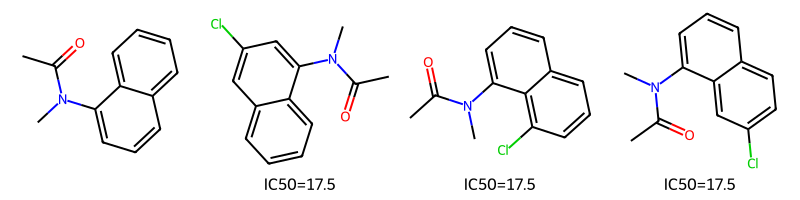

Base: アスピリン


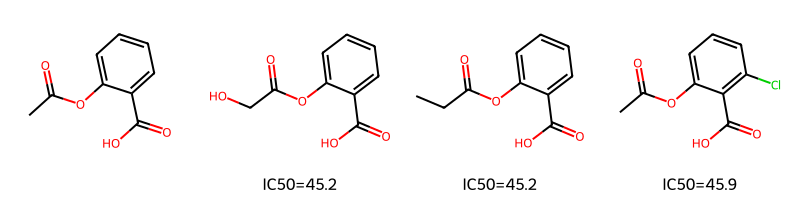

Base: ナプロキセン


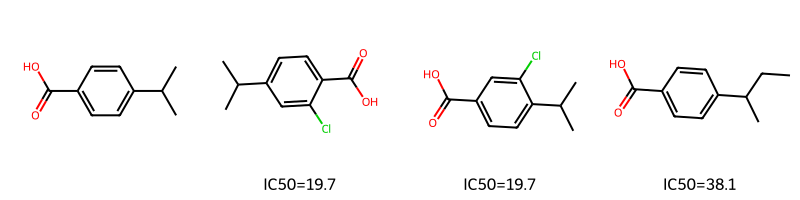

Base: ケトプロフェン


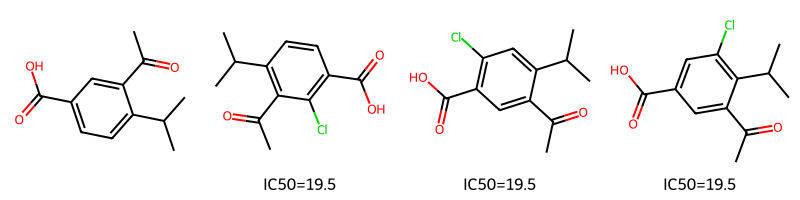

Base: イブプロフェン


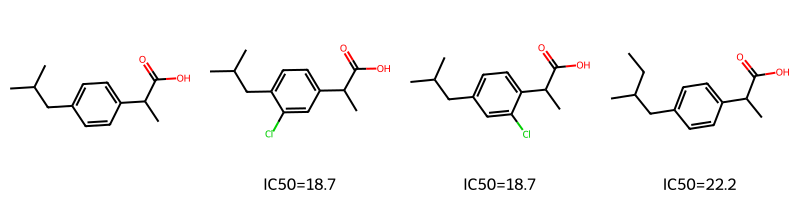

Base: メフェナム酸


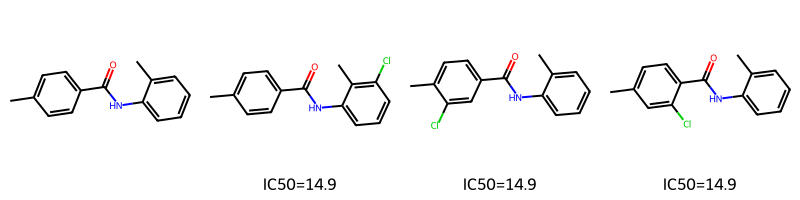

Base: ジクロフェナク


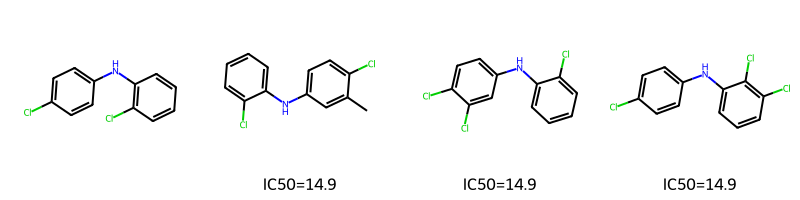

In [31]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

# 事前にベースSMILESと薬品名リスト
base_smiles_list = [
    "CC(=O)OC1=CC=CC=C1C(=O)O",       # アスピリン
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # イブプロフェン
    "CC(C)C1=CC=C(C=C1)C(O)=O",       # ナプロキセン
    "CC(C)C1=CC=C(C=C1C(=O)C)C(O)=O", # ケトプロフェン
    "CC(=O)N(C)C1=CC=CC2=CC=CC=C12",  # インドメタシン
    "Clc1ccc(cc1)Nc2c(Cl)cccc2",      # ジクロフェナク
    "CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C" # メフェナム酸
]
base_names = [
    "アスピリン", "イブプロフェン", "ナプロキセン",
    "ケトプロフェン", "インドメタシン", "ジクロフェナク", "メフェナム酸"
]
base_smiles_to_name = dict(zip(base_smiles_list, base_names))

# 1. 各base_smilesごとにTop3抽出
top3_list = []
for base, group in df_screen.groupby("base_smiles"):
    topn = group.nsmallest(3, "Predicted_IC50")
    for _, row in topn.iterrows():
        top3_list.append({
            "base_smiles": base,
            "generated_smiles": row["generated_smiles"],
            "Predicted_IC50": row["Predicted_IC50"]
        })
df_top3 = pd.DataFrame(top3_list)

# 2. ベース分子＋各トップ3変異分子の可視化（ベース＋新規の4分子で1セット）
for base in df_top3["base_smiles"].unique():
    base_mol = Chem.MolFromSmiles(base)
    subset = df_top3[df_top3["base_smiles"] == base]
    mutant_mols = [Chem.MolFromSmiles(s) for s in subset["generated_smiles"]]
    mols = [base_mol] + mutant_mols
    # ラベルを薬品名に
    base_label = base_smiles_to_name.get(base, "Base")
    legends = [base_label] + [f"IC50={ic50:.1f}" for ic50 in subset["Predicted_IC50"]]
    print(f"Base: {base_label}")
    img = Draw.MolsToGridImage(
        mols, legends=legends, molsPerRow=4, subImgSize=(200, 200)
    )
    display(img)

In [ ]:
#新規分子のIC５０
new_smiles = ""
new_desc = smiles_to_descriptors(new_smiles)
pred = model.predict([new_desc])[0]
print(f"新規分子（{new_smiles}）の予測IC50: {pred:.2f}")

In [ ]:
#新規分子の構造
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles(new_smiles)
Draw.MolToImage(mol)

In [ ]:
#特徴量重要度
import matplotlib.pyplot as plt
plt.bar(descriptor_names, model.feature_importances_)
plt.ylabel("Feature Importance")
plt.title("QSARモデルの特徴量重要度")
plt.show()

In [41]:
#定量的構造活性相関のAI
import pandas as pd

# サンプル分子データ（SMILESとIC50）
data = {
    "SMILES": [
        "CCO",                                  # エタノール
        "CC(=O)O",                              # 酢酸
        "CC(=O)OC1=CC=CC=C1C(=O)O",             # アスピリン
        "CCN(CC)CC",                            # ジエチルアミン
        "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"         # イブプロフェン
    ],
    "IC50": [400, 500, 50, 300, 30]
}
df = pd.DataFrame(data)
df
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
descriptor_names = [d[0] for d in Descriptors._descList]  # RDKit全記述子

descriptor_names = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors']
calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return list(calc.CalcDescriptors(mol))
    else:
        return [None] * len(descriptor_names)

desc = df['SMILES'].apply(smiles_to_descriptors)
desc_df = pd.DataFrame(desc.tolist(), columns=descriptor_names)
df_desc = pd.concat([df, desc_df], axis=1)
df_desc

from sklearn.ensemble import RandomForestRegressor

X = df_desc[descriptor_names]
y = df_desc["IC50"]

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

y_pred = model.predict(X)
df_desc["Predicted_IC50"] = y_pred
df_desc

new_smiles = "CC(C)O"  # イソプロパノール
new_desc = smiles_to_descriptors(new_smiles)
pred = model.predict([new_desc])
print(f"新規分子（{new_smiles}）の予測IC50: {pred[0]:.2f}")

from rdkit.Chem import Draw
Draw.MolToImage(Chem.MolFromSmiles(new_smiles))

test_smiles = ["CC(C)O", "c1ccccc1O", "CCCO"]
for s in test_smiles:
    d = smiles_to_descriptors(s)
    p = model.predict([d])[0]
    print(f"{s}: 予測IC50 = {p:.2f}")

新規分子（CC(C)O）の予測IC50: 449.80
CC(C)O: 予測IC50 = 449.80
c1ccccc1O: 予測IC50 = 347.00
CCCO: 予測IC50 = 449.80


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [40]:
from rdkit.Chem import Draw
Draw.MolToImage(Chem.MolFromSmiles(new_smiles))

test_smiles = ["CC(C)O", "c1ccccc1O", "CCCO"]
for s in test_smiles:
    d = smiles_to_descriptors(s)
    p = model.predict([d])[0]
    print(f"{s}: 予測IC50 = {p:.2f}")

CC(C)O: 予測IC50 = 449.80
c1ccccc1O: 予測IC50 = 347.00
CCCO: 予測IC50 = 449.80


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
x = 7
y = 3
print("7+3",x+y)

7+3 10


In [ ]:
for i in range(1,6):
  print("ループ番号:",i)


ループ番号: 1
ループ番号: 2
ループ番号: 3
ループ番号: 4
ループ番号: 5


アスピリン 分子量: 180.15899999999996
アスピリン LogP : 1.3101
                     smiles         name
0  CC(=O)OC1=CC=CC=C1C(=O)O      Aspirin
1        CC1=CC(=O)NC(=O)N1  Paracetamol
2  CC(C)C1=CC=C(C=C1)C(O)=O     Naproxen
                     smiles         name    MolWt     LogP
0  CC(=O)OC1=CC=CC=C1C(=O)O      Aspirin  180.159  1.31010
1        CC1=CC(=O)NC(=O)N1  Paracetamol  126.115 -0.62838
2  CC(C)C1=CC=C(C=C1)C(O)=O     Naproxen  164.204  2.50820
            MolWt      LogP
count    3.000000  3.000000
mean   156.826000  1.063307
std     27.767151  1.582787
min    126.115000 -0.628380
25%    145.159500  0.340860
50%    164.204000  1.310100
75%    172.181500  1.909150
max    180.159000  2.508200


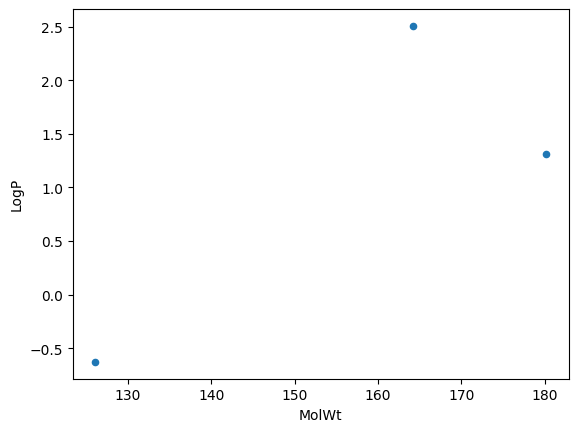

In [ ]:
!pip install rdkit -q

from rdkit import Chem
from rdkit.Chem import Descriptors

smiles_aspirin = "CC(=O)OC1=CC=CC=C1C(=O)O"
mol = Chem.MolFromSmiles(smiles_aspirin)

mw  = Descriptors.MolWt(mol)     # ← W が 大文字
logp = Descriptors.MolLogP(mol)  # ← MolLogP の L も大文字

print("アスピリン 分子量:", mw)
print("アスピリン LogP :", logp)

import pandas as pd

df= pd.read_csv("smiles_list.csv")
print(df.head())

from rdkit import Chem
from rdkit.Chem import Descriptors

def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series({"MolWt": None, "LogP": None})
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol)
    })

df_desc = df.join(df["smiles"].apply(smiles_to_descriptors))
print(df_desc)

print(df_desc[["MolWt", "LogP"]].describe())   # 平均・標準偏差
df_desc.plot.scatter(x="MolWt", y="LogP")      # 散布図（関係性ざっくり確認）

assert df_desc["MolWt"].notna().all()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')